In [38]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *

In [93]:
# no. of stimuli x2 for not-stimuli as well
nf = 2*2
stim = {
    0:"X",
    1:"Y",
    2:"NotX",
    3:"NotY"
}
# variables
dt = 0.1
a = 0.8

In [94]:
#generate a range of s and tau_star
def s_gen(tau_min=1, tau_max=100., buff_max=None, k=20, ntau=40, g=0.0):
    c = (tau_max/tau_min)**(1./(ntau-1))-1
    tau_star = tau_min*(1+c)**np.arange(ntau).astype(float)
    s = 1/tau_star
    return [tau_star, s]
[tau_star, S] = s_gen()

In [95]:
S

array([1.        , 0.88862382, 0.78965229, 0.70170383, 0.62355073,
       0.55410203, 0.49238826, 0.43754794, 0.38881552, 0.34551073,
       0.30702906, 0.27283334, 0.2424462 , 0.21544347, 0.1914482 ,
       0.17012543, 0.15117751, 0.13433993, 0.11937766, 0.10608184,
       0.09426685, 0.08376776, 0.07443803, 0.06614741, 0.05878016,
       0.05223345, 0.04641589, 0.04124626, 0.03665241, 0.03257021,
       0.02894266, 0.02571914, 0.02285464, 0.02030918, 0.01804722,
       0.01603719, 0.01425103, 0.0126638 , 0.01125336, 0.01      ])

In [96]:
def stim_gen(i):
    global nf
    stim_vec = np.zeros(nf)
    if i is not None:
        stim_vec[i] = 1
    return stim_vec

In [167]:
def input_update(a,s,s_idx,fi_IN: None):
    global M
    global F
    global P
    #if fi_IN is not None:
        #print("Inputing stim", stim[fi_IN])
    f_IN = stim_gen(fi_IN)
    #eq 1
    F[s_idx] += -s*F[s_idx] + f_IN
    F[s_idx] = np.where(F[s_idx]<0, 0, F[s_idx])
    #eq 2
    P_IN = np.dot(M[s_idx], f_IN)
    #eq 3
    P[s_idx] +=  s*P[s_idx] + P_IN - P[-1]
    P[s_idx] = np.where(P[s_idx]<0, 0, P[s_idx])
    #find stimulis from the past that are still active, update associations
    if fi_IN is not None:
        for past_stim in np.flatnonzero(F[s_idx]):
            #eq4 - make sure we're indexing M correctly
            M[s_idx][fi_IN, past_stim] = a * M[s_idx][fi_IN, past_stim] + (1-a) * F[s_idx][past_stim]
def detect_notstim(a,t,s,s_idx,fi_IN:None):
    global M
    global F
    global P
    predicted = np.where(P[s_idx]>=1)[0]
    #iterate through them
    for p in predicted:
        if p == fi_IN:
            print(stim[p], "Observed & Predicted with p=%s! at at s=%s and t=%s"
                  %(P[s_idx][p],s,t))
            P[s_idx][p] = 0
        else:
            P[s_idx][p] = 0
            if p < 2:
                print(stim[p+2], "predicted at s=%s and t=%s" %(s,t))
                #add 2 to get the not-stimuli equivalent
                input_update(a,s,s_idx,fi_IN=p+2)
            else:
                print(stim[p], "predicted at s=%s and t=%s" %(s,t))
                input_update(a,s,s_idx, fi_IN=p)
def timestep_update(a,t,S,fi_IN: None):
    for s_idx, s in enumerate(S):
        input_update(a,s,s_idx,fi_IN)
        detect_notstim(a,t,s,s_idx,fi_IN) 

In [205]:
M = np.zeros([len(S), nf, nf])
F = np.zeros([len(S), nf])
P = np.zeros([len(S), nf])
#modify in loop to change tracking element
P_tracker = np.zeros(nf)
M_tracker = list()
F_tracker = np.zeros(nf)
#alter this for different stimuli presentation at different times
t_max = 8.0
f = [[0,1],[1,1.5],[0,4],[0,10.1]]
#pick an s value to track
s_track = 10

In [206]:
T = np.arange(0,t_max, dt)
fi_prev = None
for t in T:
    if f[0][1] == t:
        fi_IN = f[0][0]
        timestep_update(a,t,S,fi_IN=fi_IN)
        f.pop(0)
    else:
        timestep_update(a,t,S,fi_IN=None)
    P_tracker = np.vstack((P_tracker,P[s_track]))
    M_tracker.append(M[s_track].copy())
    F_tracker = np.vstack((F_tracker,F[s_track]))

NotX predicted at s=1.0 and t=4.4
NotX predicted at s=0.8886238162743404 and t=4.4
NotX predicted at s=0.7896522868499728 and t=4.5
NotX predicted at s=0.701703828670383 and t=4.5
NotX predicted at s=0.6235507341273916 and t=4.6000000000000005
NotX predicted at s=0.5541020330009494 and t=4.7
NotX predicted at s=0.49238826317067413 and t=4.7
NotX predicted at s=0.4375479375074187 and t=4.800000000000001
NotX predicted at s=0.3888155180308091 and t=4.9
NotX predicted at s=0.3455107294592222 and t=5.1000000000000005
NotX predicted at s=0.3070290629757852 and t=5.2
NotX predicted at s=0.27283333764867707 and t=5.4
NotX predicted at s=0.24244620170823306 and t=5.6000000000000005
NotX predicted at s=0.21544346900318861 and t=5.800000000000001
NotX predicted at s=0.19144819761699602 and t=6.0
NotX predicted at s=0.1701254279852591 and t=6.300000000000001
NotX predicted at s=0.1511775070615664 and t=6.7
NotX predicted at s=0.1343399332598902 and t=7.1000000000000005
NotX predicted at s=0.11937

<IPython.core.display.Javascript object>


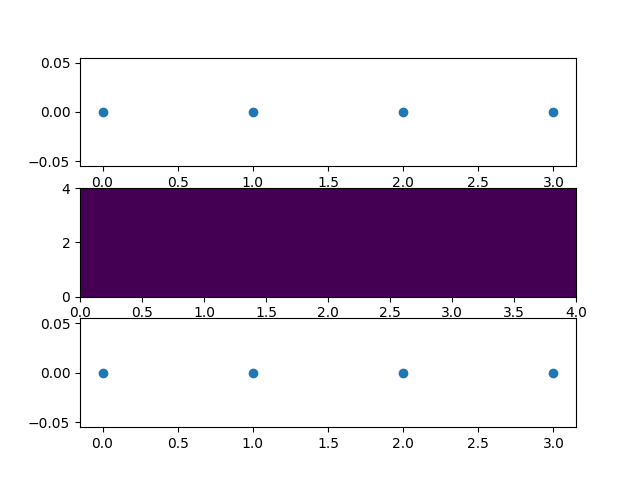

interactive(children=(FloatSlider(value=0.0, description='i', max=8.0), Output()), _dom_classes=('widget-inter…

In [207]:
%matplotlib notebook
x = np.arange(nf)
fig = plt.figure()
ax = fig.subplots(3,1)
i = 0
F_plot = ax[0].scatter(x, F_tracker[i])
P_plot = ax[2].scatter(x, P_tracker[i])
M_plot = ax[1].pcolormesh(M_tracker[i])

def update(i=0.0):
    idx = int(i*10)
    F_plot.set_offsets(np.c_[x,F_tracker[idx]])
    P_plot.set_offsets(np.c_[x,P_tracker[idx]])
    M_plot.set_array(M_tracker[idx])
    #scatter.set_ydata(Tracker[idx])
    fig.canvas.draw_idle()

interact(update, i = (0.0,t_max,dt));

<IPython.core.display.Javascript object>


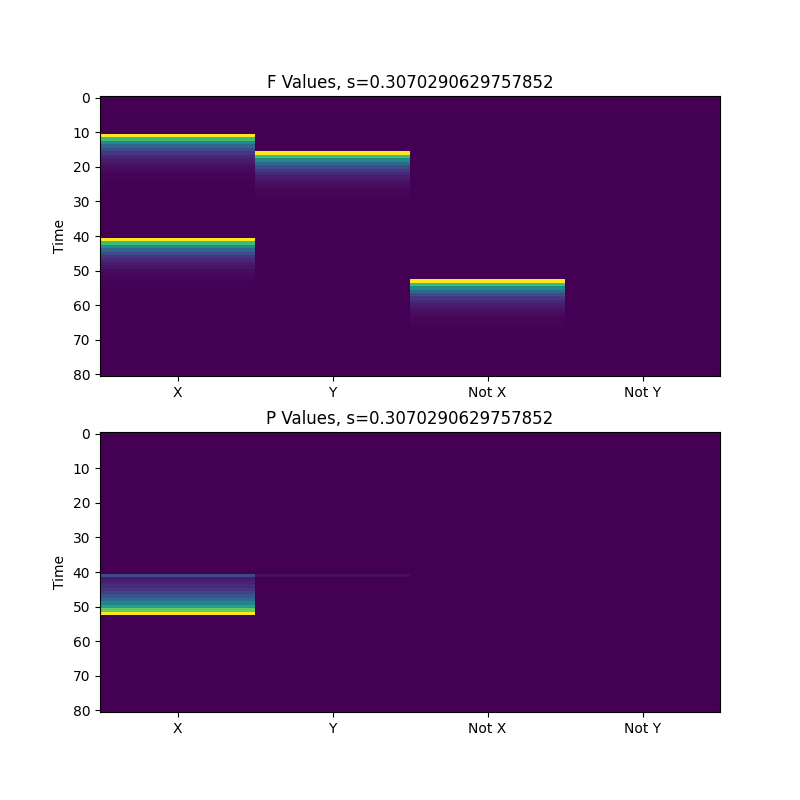

In [214]:
fig2 = plt.figure(figsize = (8,8))
ax2 = fig2.subplots(2,1)
ax2[0].imshow(F_tracker, aspect='auto')
ax2[0].set_title("F Values, s=%s" %(S[s_track]))
ax2[0].set_ylabel("Time")
ax2[0].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])
ax2[1].imshow(P_tracker, aspect='auto')
ax2[1].set_title("P Values, s=%s" %(S[s_track]))
ax2[1].set_ylabel("Time")
ax2[1].set_xticks(np.arange(4),['X', 'Y','Not X', 'Not Y'])